# Practical Session 4: Topic Analysis

*Notebook by Ekaterina Kochmar*

This practical will address the use of machine learning techniques in a specific application area (Natural Language Processing), using Topic Analysis as the task in focus.

## Learning objectives

In this practical you will learn about:
- Implementation of a supervised approach to topic classification with `sklearn`
- The use of multi-class classification for NLP tasks
- Topic discovery in an unsupervised way
- Implementation of an unsupervised approach – clustering with `sklearn`

## Your task

This code already proposes a certain implementation for you. Your task is to:
- Fill in the gaps in the code marked with #
- Answer the questions posed in the notebook
- Submit your solutions via Moodle

## Supervised Approach

First, let’s approach topic analysis using *supervised machine learning*. As is usual with supervised ML tasks, there are several key components to think about: 
- *data* labeled with the classes of interest, 
- *algorithm* to apply to this multi-class classification task, and 
- *evaluation strategy* that will help you check that your approach works well. 

Since, within the supervised ML setting you are applying classification to distinguish between different topics, we'll call this application *topic classification*.

### Data 

We’ve discussed before that for supervised ML scenarios high quality data that are labeled with the classes of interest are of utmost importance. In this practical, you are going to use the famous 20 Newsgroups dataset, that is well-suited for the topic classification task and is easily accessible via [`sklearn`](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset). 

The [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) is a collection of around 18,000 newsgroups posts on 20 topics. This dataset has been widely used in the NLP community for various tasks around text classification and, in particular, for topic classification. For the ease of comparison, the dataset is already split into *training* and *test* subsets. 

First, let's import the libraries that you will be using in this notebook. Specifically, let's import the dataset via [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups):

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

Now, let's define a function `load_dataset` that will initialize a subset of the data as the ‘*train*’ or ‘*test*’ chunk of the 20 Newsgroups dataset and will also allow you to select particular categories listed in `cats`. You need to shuffle the dataset and remove all extraneous information such as footers, headers, and quotes.

**Hint**: To solve the following tasks, check https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups

In [2]:
def load_dataset(a_set, cats):
    dataset = fetch_20newsgroups(subset= a_set, 
                                 categories= cats ,
                                 remove=('headers', 'footers', 'quotes'),
                                 shuffle= True
                                )
    return dataset

This code allows you to specify a list of categories of interest as input: the list of 10 topics below is used as an example (i.e., you can experiment with a different selection later). Finally, you initialize `newsgroups_train` and `newsgroups_test` subsets. If you use ‘*all*’ instead of ‘*train*’ or ‘*test*’, you will get access to the full 20 Newsgroups dataset, and *None* instead of categories will help you access all topics. I.e.:

- you can use `load_dataset('all', categories)` to load the whole dataset
- you can use `load_dataset('train', None)` to load the train set with all topics included

In [3]:
categories = ["comp.windows.x", "misc.forsale", "rec.autos", "rec.motorcycles", "rec.sport.baseball"]
categories += ["rec.sport.hockey", "sci.crypt", "sci.med", "sci.space", "talk.politics.mideast"]

newsgroups_train = load_dataset("train", categories)
print(newsgroups_train)
newsgroups_test = load_dataset("test", categories)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In total, you should get a subset of 5,913 training posts and 3,937 test posts. The code below shows how to check what data got uploaded and how many posts are included in each subset. In this code, you should first check what categories are uploaded using `target_names` field – this list should coincide with the one that you defined in `categories` earlier. Then, you check the number of posts (`filenames` field) and the number of labels assigned to them (`target` field) and confirm that the two numbers are the same. The `filenames` field stores file locations for the posts on your computer: for example, you can access the very first one via `filenames[0]`. The `data` field stores file contents for the posts in the dataset: for example, you can access the very first one via `data[0]`. As a final sanity check, you can also print out category labels for the first 10 posts from the dataset using `target[:10]`:

In [4]:
def check_data(dataset):
    print(list(dataset.target_names))
    print(dataset.filenames.shape)
    print(len(dataset.target))
    if dataset.filenames.shape[0]==dataset.target.shape[0]:
        print("Equal sizes for data and targets")
    print(dataset.filenames[0])
    print(dataset.data[0])
    print(dataset.target[:10])

In [5]:
check_data(newsgroups_train)
print("\n***\n")
check_data(newsgroups_test)

['comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'talk.politics.mideast']
(5913,)
5913
Equal sizes for data and targets
C:\Users\Simon\scikit_learn_data\20news_home\20news-bydate-train\rec.sport.baseball\102665
I have posted the logos of the NL East teams to alt.binaries.pictures.misc 
 Hopefully, I'll finish the series up next week with the NL West.

 Darren

[4 3 9 7 4 3 0 5 7 8]

***

['comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'talk.politics.mideast']
(3937,)
3937
Equal sizes for data and targets
C:\Users\Simon\scikit_learn_data\20news_home\20news-bydate-test\misc.forsale\76785
As the title says. I would like to sell my Star LV2010 9 pin printer.
Its a narrow colum dot matrix, supports both parallel and serial
interfacing, prints at 200 characters per second, has a 16K buffer, 
and is v

The very first line of the output should confirm that the categories have been loaded correctly. The number of posts in the training data is equal to 5913, and in the test data to 3937, as expected. Since `dataset.filenames` returns a list and `dataset.target` an array, when you check their shape you see e.g. (5913, ). This notation means that the particular data structure has a single dimension to the length of 5913 (e.g., it is a list or an array of 5913 elements).  

Note that `sklearn` allows you to not only access the dataset, it also represents it as an object with relevant attributes that can be directly accessed via `dataset.attribute`, for example:
- `target_names` returns the list of the names for the target classes (categories);
- `filenames` is the list of paths where the files are stored on your computer;
- `target` returns an array with the target labels (note that the category names are cast to the numerical format);
- `data` returns the list of the contents of the posts. 

The list of targets represents categories numerically. This is because machine learning classifiers implemented in `sklearn` prefer to work with numerical format for the labels. Numbers are assigned to categories in alphabetical order: for instance, 'comp.windows.x' corresponds to the numerical label 0, 'misc.forsale' to 1, and so on. An output like [4 3 9 7 4 3 0 5 7 8] tells you that the posts on different topics are shuffled: the first one is on rec.sport.baseball, the second one is on rec.motorcycles, and so on.

### Feature selection

Next, let's create word vectors based on the content of the posts. First of all, note that, compared to the previous applications, we’ve made the detection task more complex. We are considering 10 topics and a vast range of words (all but [stopwords](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words), i.e., very frequent words that are often uninformative for prediction tasks) occurring in newsgroups posts. Even after stopwords removal, many of the remaining words will occur not in a single topic but rather across lots of posts on various topics. Consider the word “*post*” itself as one example of such frequent and widely spread word: it might mean a new *post* that someone has got and, as such, might be more relevant to the texts on politics; at the same time, you will also see it frequently used in contexts like “I have *posted* the logos of the NL East teams to …”. That is, despite the word “*post*” not being a stopword, it is quite similar to stopwords in nature – it might be used frequently across many texts on multiple topics, and thus lose its value for the task. How can you make sure that words that occur frequently in the data are given less weight than more meaningful words that occur frequently in a restricted set of texts (e.g., restricted by a topic)?

You need to apply a technique that allows you to downweigh terms that occur frequently across many documents and upvalue terms that occur frequently only in some documents but not across the whole collection. This technique is called [**TF-IDF**](https://en.wikipedia.org/wiki/Tf–idf) for **Term Frequency – Inverse Document Frequency**. Here is a description of how it works:

- You would like to ensure that each word’s contribution is not affected by the document length – for instance, a post with 100 words may use a word “car” 2 times, while another post of 200 words may use “car” 4 times. It might seem as if the post with 4 occurrences of “car” is more focused on cars, but once you take into account the overall length of text, you notice that the actual contribution of “car” in both cases is `tf(“car”)=4/200=2/100=0.02`. This is what **term frequency (tf)** allows you to deduce.
- You would also like to ensure that word contribution is measured against its specificity. E.g., if you see a word “post” in virtually every text, its contribution should be lower than a contribution of some more topical words like “car”. This is what **inverse document frequency (idf)** allows you to take into account: if a word “post” is used in 80 posts out of 100, and “car” in 25 posts out of 100, then `idf(“post”)=100/80=1.25 < idf(“car”)=100/25=4`, i.e. “car” has much more weight by way of being less widely spread across the collection of texts.
- Finally, putting the two bits together, `TF-IDF=tf*idf` gives higher weights to words that are used frequently within some documents but not across a wide variety of documents. This technique, therefore, is very useful for our task at hand. 

Application of TF-IDF technique to raw word counts is quite straightforward in `sklearn`. You use *vectorizers* – functions that are capable of counting word occurrences in texts and then presenting each text as a vector of such word counts: for instance, [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  simply counts word occurrences, while [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), as its name suggests, performs word counting and TF-IDF weighing in one go. 

In the code below, you first initialize the vectorizer to apply to all words but stopwords. The vectorizer estimates word counts and learns the tf-idf weights on the training data (therefore, you use method `.fit_transform` and apply it to the `train_set`) and then applies the weights to the words in the test data (this is done using method `.transform` applied to the `test_set`). Using the vectorizer, you convert training and test texts into vectors and store the resulting vectors as `vectors_train` and `vectors_test`.

**Hint**: To solve some tasks in this notebook, you might need to consult `sklearn` documentation.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

vectorizer = TfidfVectorizer(stop_words = text.ENGLISH_STOP_WORDS)
def text2vec(vectorizer, train_set, test_set):
    vectors_train = vectorizer.fit_transform(train_set.data)
    vectors_test = vectorizer.transform(test_set.data)
    return vectors_train, vectors_test

vectors_train, vectors_test = text2vec(vectorizer, newsgroups_train, newsgroups_test)

Let's check how the data looks like now: you can run some checks on the vectors, e.g., check the dimensionality of the vector structures using `.shape`, see how the first training text is represented, and check which word corresponds to a particular id (for instance, 33404 in this code).

In [7]:
print(vectors_train.shape)
print(vectors_test.shape)
print(vectors_train)
print(vectorizer.get_feature_names()[33053])

(5913, 52746)
(3937, 52746)
  (0, 15218)	0.31618146678372416
  (0, 50534)	0.20153071455804605
  (0, 50435)	0.1817612919269656
  (0, 42031)	0.1891577831889085
  (0, 20349)	0.2372918776268056
  (0, 29215)	0.14244326085583361
  (0, 24214)	0.23045715683316248
  (0, 31546)	0.21952696479551445
  (0, 36274)	0.23637098993673133
  (0, 9616)	0.2606508810838842
  (0, 6736)	0.23045715683316248
  (0, 46098)	0.18751137951875305
  (0, 17820)	0.1996672692556469
  (0, 33404)	0.47274197987346267
  (0, 29330)	0.32348469409130415
  (0, 36985)	0.1806134526365663
  (1, 25677)	0.5568623831374047
  (1, 46454)	0.2653547969131275
  (1, 43396)	0.3859309475887295
  (1, 32114)	0.4234969554255155
  (1, 27831)	0.20785320309641625
  (1, 35813)	0.2234045791361397
  (1, 28785)	0.2761959084320557
  (1, 50195)	0.3490014478326173
  (2, 13605)	0.042989860759569426
  :	:
  (5911, 27841)	0.14528367455387203
  (5911, 50194)	0.11075101531721535
  (5911, 5904)	0.13020220048406514
  (5911, 29979)	0.10264130524464979
  (5911, 112

The first two lines should tell you that `vectors_train` is a matrix of 5,913 rows and 52,746 columns (or a similar number), while `vectors_test` is a matrix of 3,937 rows and 52,746 columns: you can imagine two large tables here, with each of the rows representing a text (remember, there are 5,913 training posts and 3,937 test posts) and each column representing a word. It is no coincidence that both matrices contain the same number of columns: the `TfidfTransformer` identified 52,746 non-stopwords in the training data, and it is this set of words that are used to classify texts into topics here. The method `fit_transform` then calculates tf-idf scores based on the training texts (with the `fit` part of the method) and transforms the raw counts in the training data to these scores. Finally, it applies the same transformations to the occurrences of the same 52,746 words in the test data (with the `transform` method). It is important that the tf-idf scores are learned on the training set only: this is why we only use `transform` method on the test data and do not apply `fit_transform` as this will rewrite our tf-idf scores based on the test data and we will end up with two separate sets of tf-idf scores – one fit to the training data and another to the test data. Remember that in a real-life application you would only have access to the training data and your test set might come, for example, from the future posts on your news platform.

A glimpse into the first text from the training set shows a list of references and scores: e.g., (0, 15218) with a rounded-up score of 0.32. What does this representation mean? (0, 15218) refers to the 1st text (thus, the index of 0) and 15218 is the index of the 15,219th word in the total set of 52,746 words used for classification. Which word does it correspond to? You can always check this by applying `vectorizer.get_feature_names()[index]` as you do in the code above for the 33,405th word (which turns out to be lowercased “NL” used in “NL East teams”. That is, the vectorizer collects 52,746 words, orders them alphabetically, assigns a unique identifier to each word, and finally estimates the tf-idf score (for the 15,219th word it is roughly 0.32). 

### Algorithm

Next, train the [Multinomial Naïve Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier and classify the posts from the test set into topics. 

In the following code, method `.fit` trains the classifier on the training set features (note that these are stored in `vectors_train`) and the gold standard training set labels (these are the `target` values of the `newsgroups_train`). Then, the classifier is applied to the test set feature vectors.

In [8]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.1)
clf.fit(vectors_train, newsgroups_train.target)
predictions = clf.predict(vectors_test)
print(predictions)

[1 7 3 ... 8 5 4]


This training and testing routine should look pretty familiar to you by now. There is only one new parameter, `alpha`, that this code specifies for the Naïve Bayes algorithm, which we haven’t discussed before. This is the *smoothing parameter* – see more here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html and https://en.wikipedia.org/wiki/Additive_smoothing.

### Evaluation

Finally, let's evaluate the results, extract the most informative terms per topic, and print out and visualise the confusion matrix. In the following code, you rely on `sklearn`’s [`metrics`](https://scikit-learn.org/stable/modules/model_evaluation.html) functionality that allows you to quickly evaluate your output. To identify the most informative features in each category, you first iterate through the categories using `enumerate(categories)` – this allows you to iterate through the tuples of *(category id, category name)*. Within this loop, `classifier.coef_[i]` returns a list of probabilities for the features in the i-th category, and `np.argsort` sorts this list in the increasing order (from the smallest to the largest) and returns the list of identifiers for the features.  As a result, you can extract $n$ most informative features using `[-n:]`.  You can access the word features via their unique identifiers using `vectorizer.get_feature_names()` and print out the name of the category and the corresponding most informative words. In the end, you print out the full `classification_report` as well as the top 10 informative features per category.

In [9]:
from sklearn import metrics

def show_top(classifier, categories, vectorizer, n):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top = np.argsort(classifier.coef_[i])[-n:]
        print(f'{category}: {" ".join(feature_names[top])}')
        
print(newsgroups_test.target.shape)
print(predictions.shape)
full_report = metrics.classification_report(newsgroups_test.target,
                                            predictions, target_names=newsgroups_test.target_names)
show_top(clf, categories, vectorizer, 10)

(3937,)
(3937,)
comp.windows.x: program using application windows widget use thanks motif server window
misc.forsale: asking email sell price condition new shipping offer 00 sale
rec.autos: know don new good dealer engine just like cars car
rec.motorcycles: don helmet riding just like motorcycle ride bikes dod bike
rec.sport.baseball: braves pitching hit think runs games game baseball team year
rec.sport.hockey: think year nhl season games players play hockey team game
sci.crypt: escrow people use nsa keys government clipper chip encryption key
sci.med: cadre dsl chastity n3jxp skepticism banks pitt geb gordon msg
sci.space: lunar just shuttle earth like moon orbit launch nasa space
talk.politics.mideast: just said arab turkish armenians people armenian jews israeli israel


**<font color='red'>Your task (1)</font>**: Summarise the results. Which topics have the lowest precision and lowest recall? What do these figures suggest about the classifier’s performance on these topics?

**<font color='red'>Your answer (1)</font>**: Lowest precision is for `rec.sport.hockey`, Lowest recall is for `rec.autos`. The low precision value for `rec.sport.hockey` suggests that the words used to generate a class of `rec.sport.hockey` lack the specificity required to be able to incorrectly label a sample that is negative as actually being positive, however it does manage to return many more results. In fact the `rec.sport.hockey` has the highest recall which would suggest that its threshold for a positive prediction is too high and must be lowered into not letting as many classes through. For `rec.autos` low recall suggest it does not cover the threshold to classify a specific class as many times as the others and does not have any significantly high precision and therefore the features used in the class may just be not specific enough to provide an overall accurate prediction of classes. Overall the f1-scores of each sample is very similar and accuracy wise is good, `comp.windows.x` seems to be the most successful regarding the f1-score which suggests it features are extremely good for classification correctly having a solid high balance of precision and recall, this could simply come down to it being a much more explicit topic than the others which have words which may be relevant to said topic but not particularly exclusive to that topic as a whole thus affecting the overall score in the long run, which explains the `rec.sport.hockey` which has overlapping words applicable to various topics

Finally, the code below shows how to explore the confusions that the classifier makes. In this code, you rely on `sklearn`’s [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) functionality and `matplotlib`’s plotting functionality. The `plot_confusion_matrix`’s functionality allows you to plot the predictions that the classifier makes on `vectors_test` against the actual labels from `newsgroups_test.target` using a heatmap. Additionally, you can set some further parameters: for instance, represent the number of correct and incorrect predictions using integer values format (i.e., `values_format=”0.0f”`) and highlight the decisions on the heatmap with a particular color scheme. In this code, you use blue color scheme, with the darker color representing higher numbers. Finally, you print out the confusion matrix and visualize correct predictions and confusions with a heatmap. For reference, you can also print out the categories’ ids corresponding to the categories’ names.

[[355   8   2   2   1   8  12   2   5   0]
 [  3 339  16   9   4  11   2   1   5   0]
 [  0   9 308  25   3  27   7   3   9   5]
 [  2   8  26 320   4  15   9   4   6   4]
 [  3   7   0   2 333  33   4   5   2   8]
 [  1   0   0   2   6 374   8   2   2   4]
 [  9   7   3   3   2  18 335   2   7  10]
 [  2   4   9   5   3  17   7 324  13  12]
 [  9   3   7   2   3  18  11   6 324  11]
 [  2   0   2   7   2   9  13   2   2 337]]


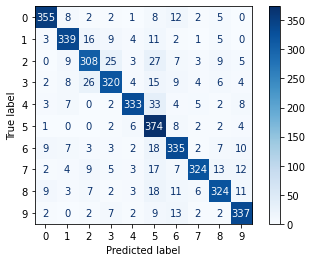

0 comp.windows.x
1 misc.forsale
2 rec.autos
3 rec.motorcycles
4 rec.sport.baseball
5 rec.sport.hockey
6 sci.crypt
7 sci.med
8 sci.space
9 talk.politics.mideast


In [10]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

classifier = clf.fit(vectors_train, newsgroups_train.target)

disp = plot_confusion_matrix(classifier, vectors_test, 
                             newsgroups_test.target,
                             values_format="0.0f",
                             cmap=plt.cm.Blues)
    
print(disp.confusion_matrix)

plt.show()
for i, category in enumerate(newsgroups_train.target_names):
    print(i, category)

**<font color='red'>Your task (2)</font>**: Summarise the results. Which categories are confused with which other ones? Does this make intuitive sense? Does this correspond to the results your saw above (e.g., precision and recall on each topic)?

**<font color='red'>Your answer (2)</font>**: `rec.sport.hockey` is the most confused one as it clearly has many words which make it classify as the incorrect class, which does intuitively make sense considering `rec.sport.baseball` which has the most confused classes with is very similar topic and thus expected to have very similar words for its topic and corresponds exactly the low precision and high recall value that `rec.sport.hockey` obtained in the results above. Similarly further evidence is with `rec.motorcylces` classes confusing itself most commonly with `rec.autos` which is the same idea of very related topics which bound to have many similar terms to identify the topics, amongst also being related to `misc.forsale` as its about selling used cars in some regards as used cars are a big part of the automobiles market and thus that explains those seriously noticeable misclassifications. 

# Unsupervised Approach

Let’s now apply the unsupervised approach to our data from the 20 Newsgroups dataset. In the previous section, you have already defined a set of posts on the selected 10 categories to work with. You are going to use the same set, only this time you will approach it as if you don’t know what the actual topic labels are. Why is this a good idea? First of all, since you know what the labels in this data actually are, you can evaluate your algorithm at the end. Secondly, you will be able to see what the algorithm identifies in the data by itself, i.e., regardless of any assigned labels. After all, it is always possible that someone who posted to one topic actually talked more about another topic. This is exactly what you are going to find out.

### Data preparation

First, let’s prepare the data for clustering. Recall that you have already extracted the data from the 20 Newsgroups dataset: there are 5,913 posts in the `newsgroups_train` and 3,937 in the `newsgroups_test`. Since clustering is an unsupervised technique, you don’t have to separate the data into two sets, so let’s combine them together in one set, `all_news_data`, which should then contain 5,913+3,937=9,850 posts all together. You are going to cluster posts based on their content (which you can extract using the `dataset.data` field); finally, let’s extract the correct labels from the data (recall from the earlier code that they are stored in the `dataset.target` field) and set them aside – you can use them later to check how the topics discovered in this unsupervised way correspond to the labels originally assigned to the posts. 

The code below walks you through these steps. Recall that it is a good idea to shuffle the data randomly, so let’s import `random` functionality and set the seed to a particular value (e.g., 42) to make sure future runs of your code return same results. Next, the code suggests that you combine the data from `newsgroups_train` and `newsgroups_test` into a single list, `all_news`, mapping the content of each post (accessible via `.data`) to its label (`.target`) and using `zip` function. After that, you shuffle the tuples and store the contents and labels separately: you will use the contents of the posts in `all_news_data` for clustering and the actual labels from `all_news_labels` to evaluate the results. Finally, you should check how many posts you have (length of `all_news_data` should equal 9,850) and how many unique labels you have using `np.unique` (the answer should be 10), and take a look into the labels to make sure you have a random shuffle of posts on different topics.

In [20]:
import random
random.seed(42)

all_news = list(zip(newsgroups_train.data, newsgroups_train.target))
all_news += list(zip(newsgroups_test.data, newsgroups_test.target))
random.shuffle(all_news)

all_news_data = [text for (text, label) in all_news]
all_news_labels = [label for (text,label) in all_news]

print("Data:")
print(str(len(all_news_data)) + " posts in "
      + str(np.unique(all_news_labels).shape[0]) + " categories\n")

print("Labels: ")
print(all_news_labels[:10])
num_clusters = np.unique(all_news_labels).shape[0]
print("Assumed number of clusters: " + str(num_clusters))

Data:
9850 posts in 10 categories

Labels: 
[2, 6, 1, 9, 0, 5, 1, 2, 9, 0]
Assumed number of clusters: 10


### Feature selection

Now the data is initialized, let’s extract the features. As before, you will use words as features and represent each post as an array, or vector, where each dimension will keep the count or tf-idf score assigned to the corresponding word: i.e., for a particular post such an array may look like [word0=0, word1=5, word2=0, …, word52745=3]. To begin with, this looks exactly like the preprocessing and feature extraction steps that you did earlier for the supervised approach. However, this time there are two issues that need to be addressed:

- Remember that to assign data points to clusters you will need to calculate distances from each data point to each cluster’s centroid. This means calculating differences between the coordinates for 9,850 data points and 10 centroids in 52,746 dimensions, and then comparing the results to detect the closest centroid. Moreover, remember that clustering uses an iterative algorithm, and you will have to perform these calculations repeatedly for, e.g., 100 iterations. This amounts to a lot of calculations, which will likely make your algorithm very slow.
- In addition, a typical post in this data is relatively short – it might contain a couple of hundreds of words, and assuming that not all of these words are unique (some may be stopwords and some may be repeated several times), the actual word observations for each post will fill in a very small fraction of 52,746 dimensions, filling most of them with zeros. That is, it would be impossible to see any post that will contain a substantial amount of the vocabulary in it and, realistically, every post will have a very small number of dimensions filled with actual occurrence numbers, while the rest will contain zeros. What a waste – not only will you end up with a huge data structure of 9,850 posts by 52,746 word dimensions that will slow your algorithm down, but you will also be using most of this structure for storing zeros. This will make the algorithm very inefficient.

What can be done to address these problems? You’ve come across some solutions to these problems before, while some others will be new for you here:
- First of all, you can ignore stopwords.
- Next, you can take into account only the words that are contained in a certain number of documents: it would make sense to ignore rare words that occur in less than some minimal number of documents (e.g., 2) or that occur across too many documents (e.g., above 50% of the dataset). You can perform all word filtering steps in one go using `TfidfVectorizer`.
- Finally, you can further compress the input data using dimensionality reduction techniques. One of such widely used techniques is [`Singular Value Decomposition`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) (SVD), which tries to capture the information from the original data matrix with a more compact matrix. SVD is an alternative for PCA (which we discussed in lectures), that is widely applied to NLP tasks, thus you will apply this technique here.

In the following code, you use [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  to convert text content to vectors ignoring all words that occur in less that 2 documents (with `min_df=2`) or in more than 50% of the documents (with `max_df=0.5`). In addition, you remove stopwords and apply inverse document frequency weights (`use_idf=True`). Within the `transform` function, you first transform the original data using a vectorizer and print out the dimensionality of this transformed data. Next, you reduce the number of original dimensions to a much smaller number using [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD ). `TruncatedSVD` is particularly suitable for sparse data like the one you are working with here (e.g., see more examples of its application to text data: [here](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)). Then, you add `TruncatedSVD` to a pipeline ([`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) from `sklearn`) together with a [`Normalizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer ), which helps adjust different ranges of values to the same range, thus helping clustering algorithm’s efficiency. As the output of the `transform` function, you return both the data with the reduced dimensionality and the `svd` mapping between the original and the reduced data. Finally, you apply the transformations to `all_news_data` to compress the original data matrix to a smaller number of features (e.g., 300) and print out the dimensionality of the new data structure.

In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

vectorizer = TfidfVectorizer(min_df=2, max_df=0.5,
                             stop_words='english',
                             use_idf=True)

def transform(data, vectorizer, dimensions):
    trans_data = vectorizer.fit_transform(data)
    print("Transformed data contains: " + str(trans_data.shape[0]) +
          " with " + str(trans_data.shape[1]) + " features =>")

    svd = TruncatedSVD(dimensions)
    pipe = make_pipeline(svd, Normalizer(copy=False))
    reduced_data = pipe.fit_transform(trans_data)

    return reduced_data, svd

In [16]:
reduced_data, svd = transform(all_news_data, vectorizer, 300)
print("Reduced data contains: " + str(reduced_data.shape[0]) +
        " with " + str(reduced_data.shape[1]) + " features")

Transformed data contains: 9850 with 33976 features =>
Reduced data contains: 9850 with 300 features


### Algorithm

Now that the data is ready, let’s apply clustering algorithm. Specifically, in the code below you use [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering algorithm from `sklearn`. You apply the algorithm with `n_clusters` defining the number of clusters to form and centroids to estimate (e.g., you can use 10 here), while `k-means++` defines an efficient way to initialize the centroids. Parameter `max_iter` defines the number of times you iterate through the dataset, and `random_state` set to a particular value ensures that you get same results every time you run the algorithm. Finally, you run the algorithm on the `reduced_data` with the number of clusters equal to 10 (recall that this is the value stored in `num_clusters`, and it’s based on the number of categories in the input data).

In [17]:
from sklearn.cluster import KMeans

def cluster(data, num_clusters):
    km = KMeans(n_clusters=num_clusters, init='k-means++', 
                max_iter=100, random_state=0)
    km.fit(data)
    return km

km = cluster(reduced_data, 10)

### Evaluation

The final step in any algorithm application is evaluation of the results. Let’s see what results you get for the clustering algorithm. The code below shows how to evaluate your clustering algorithm’s performance and extract the most informative features. To identify the most informative features, you use the clustering algorithm `km` and the SVD mapping `svd` to get back the centroids using `svd.inverse_transform` on `km.cluster_centers_`. Then, you sort them with `argsort`, and return the matrix with 10 rows (one per cluster) containing the list of most informative dimensions for the cluster centroids, sorted in a decreasing order using `[:,::-1]`. Since the resulting matrix `order_centroids` contains 10 rows with indices of the most significant words for cluster centroids, you can map them back to words using `vectorizer.get_feature_names()` and return, e.g., 50 per cluster. In the end, you print out the results, as well as the list of categories names from the original dataset for reference.

In [18]:
def evaluate(km, labels, svd):
    print("Clustering report:\n")
    print(f"* Homogeneity: {str(metrics.homogeneity_score(labels, km.labels_))}")
    print(f"* Completeness: {str(metrics.completeness_score(labels, km.labels_))}")
    print(f"* V-measure: {str(metrics.v_measure_score(labels, km.labels_))}")

    print("\nMost discriminative words per cluster:")
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(num_clusters):
        print("Cluster " + str(i) + ": ")
        cl_terms = ""
        for ind in order_centroids[i, :50]:
            cl_terms += terms[ind] + " "
        print(cl_terms + "\n")

In [19]:
evaluate(km, all_news_labels, svd)

print("\nCategories:")
for i, category in enumerate(newsgroups_train.target_names):
    print("*", category)

Clustering report:

* Homogeneity: 0.47581005839799
* Completeness: 0.5286428022351565
* V-measure: 0.5008369679879956

Most discriminative words per cluster:
Cluster 0: 
thanks window server use motif using application file windows program does display widget x11r5 code know running help sun hi like problem set xterm advance color mail version run x11 mit ve information work files openwindows source available way unix edu user error appreciated need want screen client software include 

Cluster 1: 
car cars engine new ford like dealer good miles just know don speed think ve does oil driving time power drive price buy really convertible clutch rear year used driver owner tires 000 insurance make small got problem mileage auto manual bought way right looking want little better gear buying 

Cluster 2: 
key chip clipper encryption government keys nsa escrow algorithm use des security phone secure people public law crypto privacy secret encrypted don just data bit enforcement think phones

The metrics used here try to mirror the metrics you used for supervised ML:
- *Homogeneity* measures to what extent each cluster contains only members of a single class (to a certain extent, this metric is similar to precision): for example, does cluster0 contain only posts on cryptography, and cluster1 only posts on medicine, and so on?
- *Completeness* measures whether members of a single category end up in the same cluster: for instance, have all cryptography posts ended up in cluster0, and all medicine-related posts ended up in cluster1, etc.? This is, to some extent, similar to recall.
- Finally, *V-measure* is equivalent to F-measure in the unsupervised context as it also represents a harmonic mean between the other two metrics.

The precise calculations for these metrics are different from those for precision, recall and F-measure in a supervised ML setting, and the two sets of values are not directly comparable. For more information, see a more detailed explanation of how the metrics are calculated [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). The metrics here should be interpreted in the following way: each score lies in the range of [0, 1], with perfect assignment of posts to clusters getting scores of 1 (as in this case each topic is represented with a single cluster, and each cluster contains posts only from a single topic), and the mixed up clusters resulting in scores of 0. Thus, the closer the scores are to 1, the better the clusters identified by the algorithm. The scores that you are getting here show that the clusters are not perfect and there is a fair number of posts from different topics being grouped in a single cluster as well as posts from the same topic being split across several clusters.

**<font color='red'>Your task (3)</font>**: To find out more about the precise assignment of posts to clusters, let’s try to further interpret the results looking at each cluster. You have originally used the data on the following categories: [comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.med, sci.space, talk.politics.mideast]. Based on the most informative words in each cluster, can you assign each cluster with a topic from this original list? Note that it's possible that the same cluster represents multiple topics, and that the same topic is split between multiple clusters.

**<font color='red'>Your answer (3)</font>**: *Provide your answer here – for each cluster, suggest at least one suitable topic from the list.*


cluster 0 - comp.windows.x
cluster 1 - rec.autos
cluster 2 - sci.crypt
cluster 3 - rec.sport.hockey (alternatively rec.sport.baseball, seems the cluster has clumped them together)
cluster 4 - sci.space
cluster 5 - rec.motorcycles
cluster 6 - sci.med
cluster 7 - misc.forsale
cluster 8 - talk.politics.mideast
cluster 9 - rec.autos (not entirely clear)